In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB


The forum data was scraped from https://forum.metacartel.org/ using the Scrape_MC_forum.py script.
The funded projects list is from https://airtable.com/appWsfebn79bII12n/tblA2NXylnlVE9eIW/viw5H4Aaxv3XsyI0e?blocks=hide in the tab called "MC Grants Proposal Portfolio". 

In [2]:
forum_data = pd.read_csv('scraped_forum_data.csv')
mc_funded_data = pd.read_csv('mc_funded_projects.csv')[0:19]

In order to merge these datasets, I tried to match the names of the projects to titles of forum posts. Four projects had no matching forum post:

In [3]:
matching_names = []
projects_with_no_match_in_forum = []

for i, project in mc_funded_data.iterrows():
    
    if pd.isna(project['Project Name']):
        matching_names.append(np.nan)
        continue
        
    matching_titles = [title for title in forum_data['title'] if project['Project Name'] in title]
    
    if len(matching_titles) > 0:
        matching_names.append(matching_titles[0])
    else:
        matching_names.append(np.nan)
        projects_with_no_match_in_forum.append(project['Project Name'])

print('No matching forum post:')
print(projects_with_no_match_in_forum)


No matching forum post:
['Overlay', 'MyMeta', 'A proposal for 5000 DAI to sponsor the NFT hackathon', 'Fork The World']


Merging the datasets and cleaning them up:

In [4]:
mc_funded_data['Matching Title'] = matching_names

forum_data = forum_data.merge(mc_funded_data, how='left', left_on='title', right_on='Matching Title')
forum_data = forum_data.drop_duplicates(subset=['description'])

forum_data['was_funded'] = np.where(pd.isnull(forum_data['$ Amount']), 0, 1)

forum_data['Date'] = pd.to_datetime(forum_data['time_posted'])
forum_data['Date'] = forum_data['Date'].apply(lambda x: x.date())

forum_data['description'] = forum_data['description'].apply(lambda x: str(x).lower())

forum_data = forum_data[['title', 'author', 'description', 'comments', 'Person Contact', 
                        'Description', '$ Amount', 'Date', 'was_funded']]

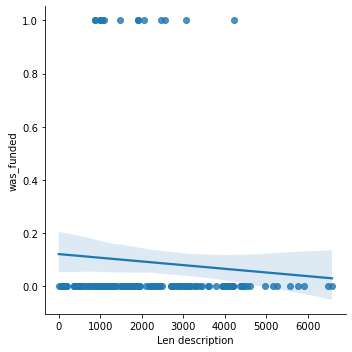

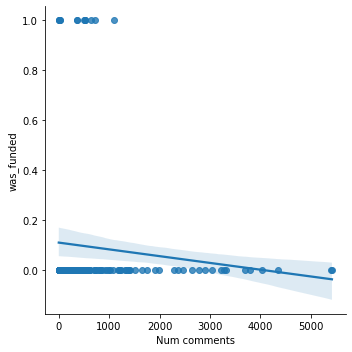

In [6]:
forum_data['Num comments'] = forum_data['comments'].apply(lambda x: len(x))
forum_data['Len description'] = forum_data['description'].apply(lambda x: len(str(x)))

sns.lmplot(x='Len description', y='was_funded', data=forum_data)
plt.show()

sns.lmplot(x='Num comments', y='was_funded', data=forum_data)
plt.show()


In [8]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~'])
    return punctuationfree

def remove_html_tags(raw_html):
    cleantext = re.sub(re.compile('<.*?>'), '', raw_html)
    return cleantext

def clean_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [9]:
forum_data['Description_cleaned'] = forum_data['description'].apply(lambda x:clean_html(x))  
forum_data['Description_cleaned'] = forum_data['Description_cleaned'].apply(lambda x:remove_punctuation(x))  

In [10]:
forum_data[['title', 'author', 'Description_cleaned', 'comments', 'was_funded', '$ Amount']].head()

,title,author,Description_cleaned,comments,was_funded,$ Amount
0,Proposal: Saints and Sinners - 🔥 DAO Proposals...,rg203,title saints and sinners description we are a...,"[(<p>Super cool! kinda feels like Wargames, bu...",0,NaN
1,Yapeswap DAO: ERC-1155/ERC-20 Compatible AMM p...,Torg,description\nwe are building liquidity pools ...,[],0,NaN
2,Gig Protocol Grant Proposal - 🔥 DAO Proposals ...,jacobean,hi everyone thank you for the opportunity to ...,"[(<p>Hey <a class=""mention"" href=""/u/jacobean""...",0,NaN
3,Truckin' Coins Proposal - 🔥 DAO Proposals - 🤩 ...,TruckinCoins,truckin’ coins problem\nas you can currently ...,[],0,NaN
4,Tokenize Community Engagement - 🔥 DAO Proposal...,Autocrat,\npath to oblivion1638×2048 355 kb\n proo...,"[(<p>Had a good chat with <a class=""mention"" h...",0,NaN


In [19]:
#Xtrain, Xtest, ytrain, ytest = train_test_split(forum_data[['Description_cleaned']], forum_data['was_funded'])

tfv = TfidfVectorizer(stop_words = 'english')

tfv.fit(forum_data['Description_cleaned'])
X_tfv =  tfv.transform(forum_data['Description_cleaned']) 

clf = BernoulliNB()
clf.fit(X_tfv.toarray(), forum_data['was_funded'])

neg_class_prob = clf.feature_log_prob_[0, :]
pos_class_prob = clf.feature_log_prob_[1, :]

zipped = list(zip(tfv.get_feature_names_out(), pos_class_prob - neg_class_prob))
zipped = sorted(zipped, key=lambda t: t[1], reverse=False)

copy_forum_data = forum_data.copy()

common_words = []
for word, score in zipped:
    copy_forum_data[word] = copy_forum_data['Description_cleaned'].apply(lambda x: ' '+word+' ' in str(x))
    if copy_forum_data[word].sum() > 5:
        common_words.append((word,score))



/var/folders/jx/j1wbyrrx4nj_lt0t2zcqk6pr0000gn/T/ipykernel_41635/3436783801.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_forum_data[word] = copy_forum_data['Description_cleaned'].apply(lambda x: ' '+word+' ' in str(x))


In [100]:
top_words = sorted(common_words, key=lambda t: t[1], reverse=False)
for word, score in top_words[1:200]:
    print(word)

think
resources
idea
decentralized
small
end
fees
live
receive
validation
platforms
add
model
description
price
total
following
potential
revenue
technology
using
wallet
week
years
business
contract
digital
does
existing
experience
liquidity
months
want
active
data
develop
differentiation
future
providing
vision
marketing
paid
make
art
bring
companies
run
smart
ux
need
problem
20
adoption
cover
going
industry
manifestovision
models
ready
solution
eth
web3
applications
deployed
grants
helping
integrating
let
main
media
necessary
really
similar
various
like
market
money
developing
explore
marketplace
membership
online
party
protocols
research
seeking
specific
step
telegram
understand
work
start
current
open
ago
audience
background
base
big
block
buying
check
details
developed
engagement
experiences
fee
founders
general
great
includes
initiative
integration
interesting
making
minting
professional
read
received
recently
rewards
selling
sense
service
services
short
social
stream
teams
today

In [66]:
def plot_word(forum_data, word):
    
    copy_forum_data = forum_data.copy()
    
    copy_forum_data[word] = copy_forum_data['Description_cleaned'].apply(lambda x: ' '+word+' ' in str(x))
        
    print(f'Number of forum posts with keyword \'{word}\':', copy_forum_data[word].sum())
    sns.barplot(x=word, y='was_funded', data=copy_forum_data, errwidth=0.5)
    plt.ylabel('Was funded')
    plt.show()


Number of forum posts with keyword 'creation': 7


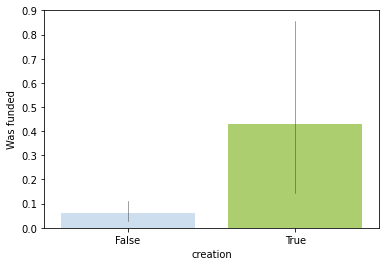

Number of forum posts with keyword 'transactions': 7


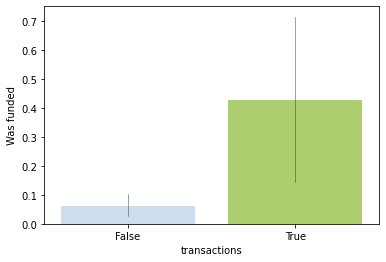

Number of forum posts with keyword '5k': 8


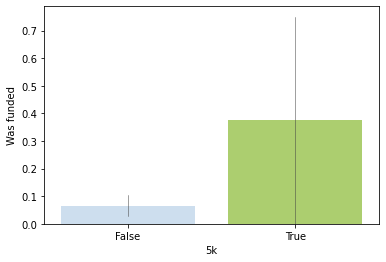

Number of forum posts with keyword 'got': 8


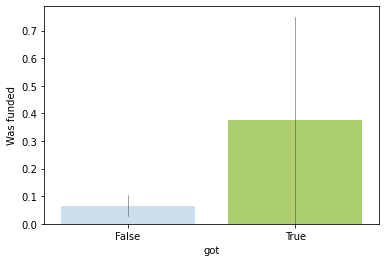

Number of forum posts with keyword 'deployment': 10


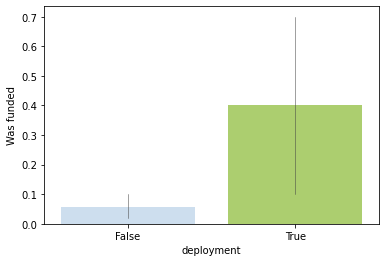

Number of forum posts with keyword 'cartel': 6


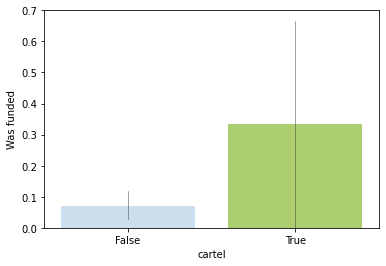

Number of forum posts with keyword 'considering': 6


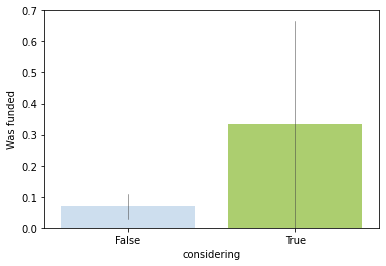

Number of forum posts with keyword 'easier': 6


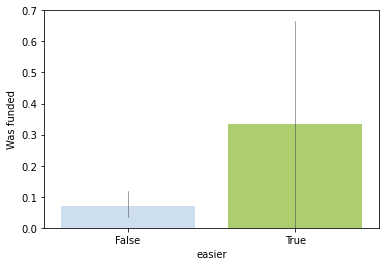

Number of forum posts with keyword 'engineer': 6


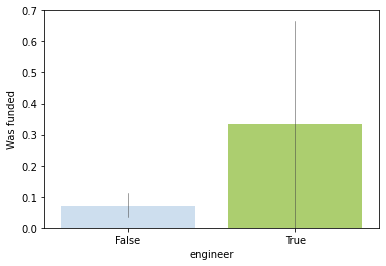

Number of forum posts with keyword 'owner': 6


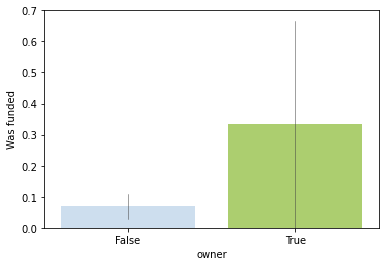

In [67]:
colors = ["#c7def4", "#b1de5f"]
sns.set_palette(colors)

for word, score in top_words[0:10]:
    plot_word(forum_data, word)

In [126]:
word = 'art'
copy_forum_data = forum_data.copy()
copy_forum_data[word] = copy_forum_data['Description_cleaned'].apply(lambda x: ' '+word+' ' in str(x))
print(copy_forum_data[copy_forum_data[word] == 1])
print(copy_forum_data[word].sum())
copy_forum_data[copy_forum_data[word] == 1].iloc[10]['Description_cleaned']




                                                 title              author  \
0    Proposal: Saints and Sinners - 🔥 DAO Proposals...               rg203   
7    PROPOSAL: Chess. Crypto. Cultivation - 🔥 DAO P...  endgameassociation   
10   Proposal: $ANIMAL Creator Token - 🔥 DAO Propos...             jdshutt   
17   Atlantis World // Grant Proposal - 🔥 DAO Propo...              revrfg   
25   LabelDAO Grant Application - 🔥 DAO Proposals -...     davidgreenstein   
27   Giving Tree : a DAO for small, local random ac...      zuchinni_hands   
28   Proposal: Minty, a DAO hub for collector DAOs ...          isaacpatka   
29   DAO Proposal: RenaissanceDAO Grant Application...          TheAlexYao   
58   DAO Proposal: Trust - A Graphic Novel that Tea...        AnneConnelly   
89   DAO Proposal: Loft Radio 🎧 - 🔥 DAO Proposals -...             jzstern   
108  DAO Proposal: MetaFactory 🤖 - 🔥 DAO Proposals ...         burningfiat   
109  DAO Proposal: KIPA is an extension for minting...          

' httpsmetafactoryai  metafactory is seeking to finalize its grant of 6000 usd to help fund the initial development of the metafactory auction platform this grant was originally proposed and approved via soft consensus under metacartel’s cohort i wave iii as swagdao httpsmediumcommetacartelmetacartelcohort16336cdca05db all grant funding will be used to pay for platform development costs only and will be directly redistributed to the teams and developers who wrote the contracts  front end metafactory is a new type of physical goods auction platform with a focus on apparel empowering artists to expand their audience and reach through fashion we curate and manage our product marketplace cultivate community engagement and handle all product production  fulfillment on behalf of our design partners so they only need to focus on their art  the auction platform includes some exciting game mechanics and enables supporters to be directly rewarded through a pro rata refund  metafactory believes i

Number of forum posts with keyword 'artists': 8


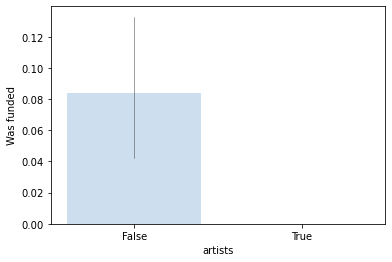

In [118]:
plot_word(forum_data, 'artists')

In [81]:
len(forum_data)

151